# 0. Overview and Outline
This notebook introduces and develops the idea of 'orthogonal' matched filters, which are able to ignore a specific nuisance component in a waveform.  This would solve many issues both online and offline related to pulse-amplitude measurement in noisy and high-rate environments.

Some of what I describe here is definitely not new, at least to a signal processing student (ie. section 1). I believe what follows after that, however, is new or at least it is not well known amongst Particle Physicists who tend to use complex, iterative template fitting procedures (such as on the g-2 experiment, MuLan experiments and so on).  The key benefit of the techniques described here is its simplicity, which brings with it far greater speed and reliability.

### Table of Contents

 1. [Introduction: The matched filter and pulse fitting](#Introduction:-The-Matched-Filter-and-Pulse-Fitting)
 2. [Two-component signals and orthogonal filters](#2.-Two-component-Signals-and-Orthogonal-Filters)
 2. [Example: Recovery of a moving pedestal](#3.-Example:-Recovery-of-a-moving-pedestal)
 2. [Pile-up separation with orthogonal filters](#4.-Pile-up-Separation-with-Orthogonal-Filters)
 2. [Recovering the time of pile-up pulses with a pedestal-orthogonal rising-edge filter](#5.-Recovering-the-Time-of-Pile-up-Pulses:-a-Pedestal-Orthogonal-Rising-Edge-Filter)
 2. [Future Areas for Development](#6.-Future-Areas-for-Development)

# 1. Introduction: The Matched Filter and Pulse Fitting
A least-squares linear-regression fit of a parametrised function to (1-dimensional) data will find the set of parameters that minimises the sum of the squares of the residuals.  More mathematically speaking, if we have data points $(x,y)_i$ for the $i$-th element in the dataset, and we wish to find a function $f(x;p_1,p_2,\ldots)$ that best describes y, then we wish to minimize:
$$
\chi^2 = \sum_i \left(y_i - f(x_i)\right)^2
$$

If the shape of the function, $f(x)$, is known and the only free parameter to be fitted is the overall scale of the function (ie. $f(x) = a g(x)$ for some scale factor, $a$), then the above equation can be solved analytically, by asking how $\chi^2$ changes with $a$:
$$
\frac{d\chi^2}{da} = a\sum_i g(x_i)\left(y_i - a g(x_i)\right) 
$$

At the minima, $d\chi^2/da$ is 0 and so the optimal value of $a$ that minimizes $\chi^2$ arises when:
\begin{align}
\sum_i  \left[ g(x_i)\left(y_i - a g(x_i)\right)\right]&=0 \\
\sum_i g(x_i)y_i &= a \sum_j \left(g(x_j)\right)^2 \\
a &= \frac{\sum_i g(x_i)y_i}{\sum_j \left(g(x_j)\right)^2}
\end{align}

We said we knew what the function, $g(x)$ looked like, so before we begin the actual calculation, we can calculate $\sum_i g(x_i)^2$.  Since we only deal with sampled (or discrete) data, we can rewrite $g(x_i)$ as $T_i$ ($T$ for template, as this will become our template function), and we can switch to vector notation so that $\mathbf{y}=(y_1,y_2,\ldots,y_N)$ and $\mathbf{T}=(T_1,T_2,\ldots,T_N)$.  As such we can rewrite the above equation as:
$$
a = \frac{ \mathbf{y}\cdot\mathbf{T} } { | \mathbf{T} | ^2 }
$$

### The Matched Filter
In digital signal processing we often have regularly sampled data (our $x_i$ are evenly spaced). 
We can model the value of the $i$_th sample in the signal as:
$$
S_i = aT_{i-k} + \epsilon_i
$$
where $T_{i-k}$ is the contribution of the true pulse of the signal, which is offset by $k$ samples and scaled by this pulse's amplitude, $a$, and $\epsilon$ represents the random noise that will inevitably occur for any electronic signal.

The previous equations show that for a given position in the signal, the value of $a$ that minimizes the value of $\chi^2$ can be found by taking the dot product of the observed signal with the known shape of a pulse (the template).
We scan through the signal (ie. increase $i$) and calculate $a$ at each location.  In other words, we convolve the signal with template function, $T_i$:
\begin{align}
F_i =& \sum_j S_j T_{j-i}\\
    =& a\sum_j T_{j-k} T_{j-i} + \sum_j\epsilon_j T_{j-i}\\
\end{align}
where $F_i$ is the $i$-th output of the filtered signal, and the first term in the expansion can be understand as the autocorrelation function of the template and the second term understood as the noise term on the filtered output.
Clearly, $\sum_j T_{j-k} T_{j-i}$ is maximal when $i=k$, meaning that to find both the time and amplitude of the pulse it is enough to find the maximum value of the filter, ie:
\begin{align}
k = & \underset{i}{\operatorname{argmax}}( F_i) \\
a = &\max_i( F_i )
\end{align}

### Relevance to Particle Physics
In particle physics, such signals will often encode the arrival of a particle at a detector, as a pulse with a finite duration (at least from a practical perspective).  The challenge of the signals processing is to extract from the signal the magnitude and timing of each pulse.  However, there are comlpications that make achieving this goal more difficult:
 - The fact that most signals have random noise in them
 - Pulses may overlap with other pulses (known as pile-up)
 - The signal processing algorithms may themselves be limited by the amount of time available to make a decision, or the amount of memory and processing power available, particularly if they are supposed to run online, in real time.



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,6
from math import exp 
#import argparse

In [2]:
def norm(funct):
    return np.sqrt(np.dot(funct,funct))

def response_one(x,shape_time=40,offset=10):
    x_off=float(x-offset)
    ret_val=x_off*exp(1-float(x_off)/float(shape_time)) if x_off>0 else 0
    return ret_val

response_vect=np.vectorize(response_one,otypes="f")
def response(x,shape_time=40,offset=10):
    values=response_vect(x,shape_time,offset)
    scale=np.max(values)
    #scale=norm(values)
    values/=scale
    return values
    
class Waveform():
    def __init__(self,pulse_list,noise,length=1000,shaping_time=40,pedestal=0):
        self.noise_val=noise
        self.pedestal_val=pedestal
        self.shaping_time=shaping_time
        self.pulse_list=pulse_list
        
        # Now create the actual waveform
        self.x=np.linspace(0,length,length)
        self.waveform=np.zeros(length)
        self.components=[]
        for time,amp in pulse_list:
            comp=response(self.x,offset=time,shape_time=shaping_time)*amp     
            self.waveform+=comp
            self.components.append(comp)
        self.noise=np.random.normal(size=length)*noise
        self.waveform+=self.noise
        self.pedestal=np.ones(length)*pedestal
        self.waveform+=self.pedestal

    def plot_all(self,show_noise=False):
        plt.plot(self.x,self.waveform,"#ff5555",label="Signal",zorder=0)
        plt.plot(self.x,self.pedestal,"k--",label="Pedestal")
        if show_noise:
            plt.plot(self.x,self.noise,"#666666",label="Noise",linewidth=0.5)
        for i,comp in enumerate(self.components):
            label="Pulse %d"%(i+1) if len(self.components)>1 else "Pulse"
            not_zero=(comp>=1) | (comp>=0.005*np.max(comp))
            plt.plot(self.x[not_zero],comp[not_zero],"b",label=label)
        plt.hlines(0,*plt.xlim(),lw=0.5)
        plt.xlabel("Time (clock ticks)")
        title="Waveform with %d pulse%s, noise=%d, and pedestal offset=%d"%(
                len(self.components),"s" if len(self.components)>1 else "",
                self.noise_val,self.pedestal_val)
        plt.title(title)
    
    def compare(self,found_peaks,filter_list,filter_names,precision=3,print_true=True):
        print("Found",len(found_peaks),"pulses compared to",len(self.pulse_list),"original pulses:")
        if isinstance(filter_names,str): filter_names=[filter_names]
        headers=["Recovered:"," time "]+filter_names
        rows=[]
        precision=pow(10,precision)
        for i,peak in enumerate(found_peaks):
            amps=[]
            for filt in filter_list:
                amp=0
                if len(filt)==len(found_peaks):
                    amp=filt[i]
                else: amp=filt[peak]
                amps.append(int(amp*precision)/precision)
            rows.append([i,peak]+amps)
        self.__table(headers,rows)
        if not print_true: return
        headers=["Original: "," time ","amplitude","pedestal"]
        rows=[]
        for i,(time,amp) in enumerate(self.pulse_list):
            rows.append([i,time,amp,self.pedestal_val])
        self.__table(headers,rows)
        
    def __table(self,header,rows):
        format_str="".join([ "{"+str(i)+": >"+str(len(title)+2)+"}" for i,title in enumerate(header)])
        print(format_str.format(*header))
        for row in rows:
            print(format_str.format(*row))

## An example waveform
Waveforms will contain multiple components:
- Noise
- Pedestal
- One or more actual signal pulses

Here we assume that the shape of a signal pulse is given by the expression:
$
f(x;\tau) = x e^{1- x/\tau }
$

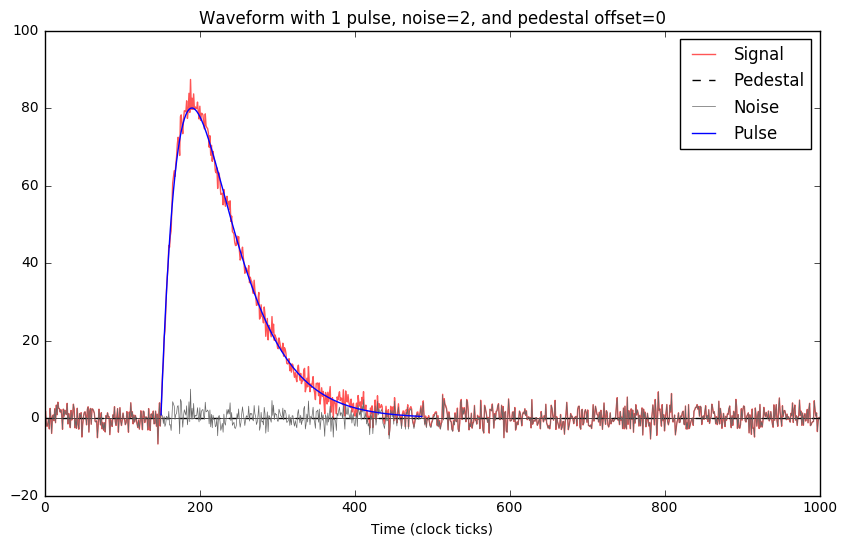

In [3]:
wave=Waveform([[150,80]],noise=2,pedestal=0)
wave.plot_all(show_noise=True)
plt.legend()

## Template pulse
Now we set up our template pulse.  We cheat here and use the analytic expression that we know is being used to generate the pulses, but in a real situation this would be a sizeable task, involving pulse registration and averaging.

We also fix all pulse shaping times from here on, to 50 ticks.

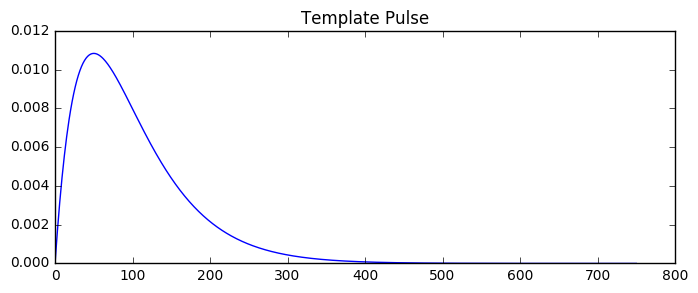

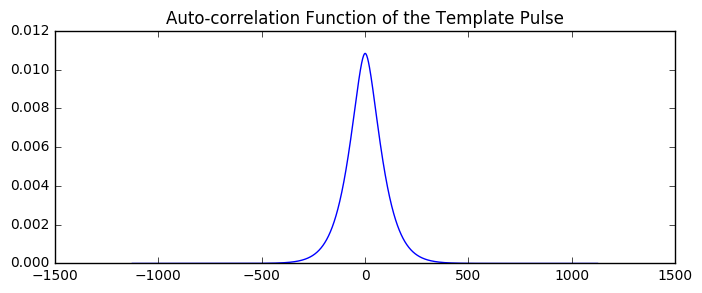

In [4]:
shaping_time=50
tpl_len=15*shaping_time # Make sure we have enough ticks to see the shape
tpl_x=np.linspace(0,tpl_len,num=tpl_len)
template=response(tpl_x,shape_time=shaping_time,offset=0)
template/=np.dot(template,template)

plt.figure(figsize=(8,3))
plt.plot(tpl_x,template)
plt.title("Template Pulse")

# Test the auto-corrlation function
template_ext=np.concatenate([[0.]*tpl_len,template,[0.]*tpl_len])
tpl_x_ext=np.concatenate([tpl_x - np.max(tpl_x)-1,tpl_x,tpl_x+np.max(tpl_x)])-tpl_len/2
matched=np.correlate(template_ext,template,mode="same")

plt.figure(2,figsize=(8,3))
plt.plot(tpl_x_ext,matched)
plt.title("Auto-correlation Function of the Template Pulse");

## Applying the Matched Filter
Now we apply the template pulse to the output waveform. Notice how by simply taking the maximum peak in the filtered output we recover both the time and amplitude of the pulse, even for large values of the noise.

In [5]:
def matched_filter(wave,filter_form):
    if isinstance(wave,Waveform):
        wave=wave.waveform
    return np.correlate(wave,filter_form,mode="valid")

def find_peaks(waveform,threshold):
    """Find maxima by checking for zero crossings in the derivative and applying a threshold"""
    deriv=np.sign(waveform[1:] - waveform[:-1])
    crossings=(deriv[1:] - deriv[:-1])==-2
    above_thresh=waveform[1:-1]>threshold
    positions=np.where(crossings & above_thresh)[0]+1
    return positions

def find_largest_peaks(waveform,n_peaks):
    peaks=find_peaks(waveform,1)
    sort_peaks=np.argsort(waveform[peaks])
    sort_peaks=peaks[sort_peaks][-n_peaks:]
    if len(sort_peaks)==1: return sort_peaks[0]
    return np.sort(sort_peaks)

def plot_peaks(peaks,heights,colour="purple",label=None,zorder=1):
    if len(peaks)<len(heights):
        peaks=peaks[peaks<len(heights)]
        heights=heights[peaks]
    plt.vlines(peaks,0,heights,color=colour,linewidth=2,label=label,zorder=zorder)
    xlims=plt.xlim()
    plt.scatter(peaks,heights,marker="o",color=colour,s=50,zorder=zorder)
    ylims=plt.ylim()
    plt.vlines(peaks,0,ylims[1],color=colour,linewidth=0.5,linestyles="--",zorder=zorder)
    plt.ylim(*ylims)
    plt.xlim(*xlims)

Found 12 pulses compared to 3 original pulses:
  Recovered:   time   amplitude
           0     300    441.866
           1     917     21.793
           2     923     21.719
           3     928     21.714
           4     933     21.646
           5     939      21.34
           6     944     21.249
           7     971     22.247
           8     981     22.799
           9     983       22.8
          10     985     22.794
          11    1757    197.096
  Original:    time   amplitude  pedestal
           0     300        450         0
           1    1000         25         0
           2    1755        200         0


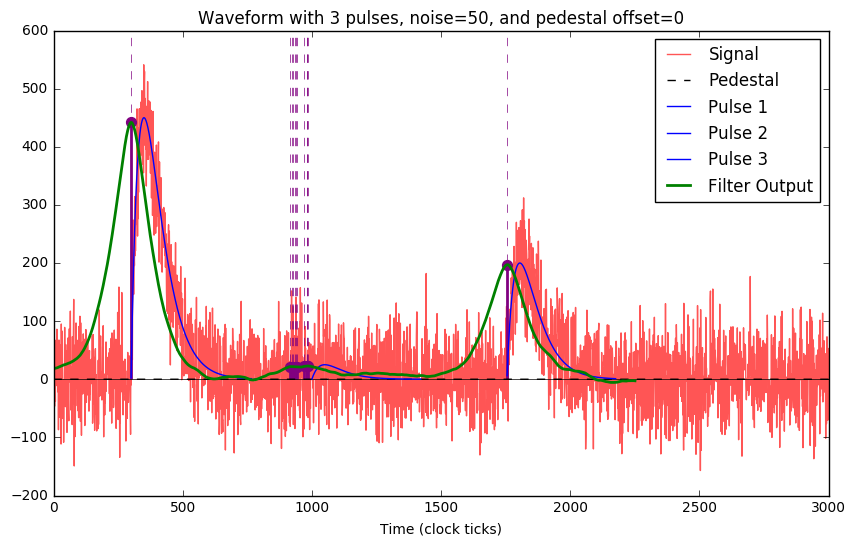

In [6]:
def demo_matched_filter(pulse_list,pulse_tpl,noise,pedestal=0,peak_threshold=None):
    if not peak_threshold: peak_threshold=noise*1.5+pedestal*1.5
    wf=Waveform(pulse_list,noise=noise,shaping_time=shaping_time,length=3000,pedestal=pedestal)
    matched=matched_filter(wf,pulse_tpl)
    peaks=find_peaks(matched,peak_threshold)

    wf.plot_all()
    plt.plot(wf.x[:len(matched)],matched,label="Filter Output",color="green",lw=2)
    plot_peaks(peaks,matched)
    plt.legend()
    wf.compare(peaks,[matched],"amplitude")

# Make a test waveform and run the 'matched filter' with the basic template
pulse_list=np.array([[300,450],[1000,25],[1755,200]])
demo_matched_filter(pulse_list,template,noise=50,peak_threshold=20)

# 2. Two-component Signals and Orthogonal Filters
Sometimes we might want to recover two parameters from our waveform.
That could be one interesting parameter (like the amplitude of a pulse) and a nuisance parameter (such as the position of the pedestal or baseline).  It might be that we have two overlapping pulses and wish to recover the parameter of each one.  Mathematically, this means our signal will now become:

$$
S_i = aT_{i-k} + bV_{i-m} + \epsilon_i
$$
where $a$ and $b$ are the amplitudes of the contribution of each component, $T$ and $V$ respectively, and $\epsilon$ is the noise contribution as before.

In this case, the simple matched filter for a single component can become confused since the output of that filter will contain contributions from both components in the waveform.  In general, the two components of the signal may overlap:
$$
\mathbf{T}\cdot\mathbf{V}=\sum_iT_iV_i \ne 0
$$

However, we can orthogonalise the components by setting:
$$
\mathbf{V'} = \mathbf{V} - \frac{\mathbf{V}\cdot\mathbf{T}}{\mathbf{T}\cdot\mathbf{T}}\mathbf{T}
$$
such that:
\begin{align}
\mathbf{V'}\cdot\mathbf{T} = &
                                \mathbf{V}\cdot\mathbf{T} 
                                - \left(\frac{\mathbf{V}\cdot\mathbf{T}}{\mathbf{T}\cdot\mathbf{T}}\right)\mathbf{T}\cdot\mathbf{T}  \\
                           = & \mathbf{V}\cdot\mathbf{T}\left(
                           1 - \frac{\mathbf{T}\cdot\mathbf{T}}{\mathbf{T}\cdot\mathbf{T}}
                           \right)
                           = 0
\end{align}

And now:
\begin{align}
\mathbf{S}\cdot\mathbf{V'} = & a \mathbf{T}\cdot\mathbf{V'} + b \mathbf{V}\cdot\mathbf{V'} \\
                           = & b \mathbf{V}\cdot\mathbf{V'} \\
\end{align}

We can go a step further and define a normalised version of $\mathbf{V'}$, which we'll call $\mathbf{\widehat{V'}}$, such that $\mathbf{\widehat{V'}}\cdot\mathbf{V}=1$:
$$
\mathbf{\widehat{V'}} = \frac{\mathbf{V'}}{\mathbf{V'}\cdot\mathbf{V}}
$$
where:
\begin{align}
\mathbf{V}\cdot\mathbf{V'} = & 
                           \mathbf{V}\cdot\left(\mathbf{V} 
                           - \frac{\mathbf{V}\cdot\mathbf{T}}{\mathbf{T}\cdot\mathbf{T}}\mathbf{T}\right) \\
                           = & 
                           \mathbf{V}\cdot\mathbf{V} 
                           - \frac{\left(\mathbf{V}\cdot\mathbf{T}\right)^2}{\mathbf{T}\cdot\mathbf{T}} \\
\end{align}

**Note** that $\mathbf{\widehat{V'}}$ should not be referred to as orthonormal because $\mathbf{\widehat{V'}} \cdot\mathbf{\widehat{V'}}\ne1$ 

Now if apply $\mathbf{\widehat{V'}}$ to our signal we see that:
\begin{align}
\mathbf{S}\cdot\mathbf{\widehat{V'}} = & a \mathbf{T}\cdot\mathbf{\widehat{V'}} + b \mathbf{V}\cdot\mathbf{\widehat{V'}} \\
                           = & b \mathbf{V}\cdot\mathbf{\widehat{V'}} \\
                           = & b
\end{align}

# 3. Example: Recovery of a moving pedestal
It's easier to explain this with a concrete example, for which we'll use the case where our pedestal shifts around.
This can happen because of residual charge on a detector, or due to integration of noise in the analogue preprocessing stages of the signal, or when there's a slow varying (low-frequency) noise being picked up.

In the case where the two components in our signal consist of a pulse and a flat pedestal, the signal will be given by:
$$
S_i = aT_{i-k} + bP_i + \epsilon_i
$$
where $P_i$ represents the pedestal contribution, and since we take the pedestal to be flat:
$$
P_i = \textrm{const}
$$

## The Standard Matched Filter and a Shifting Pedestal

Found 2 pulses compared to 2 original pulses:
  Recovered:   time   amplitude
           0     300    845.173
           1    1700    589.937
  Original:    time   amplitude  pedestal
           0     300        550       200
           1    1700        300       200


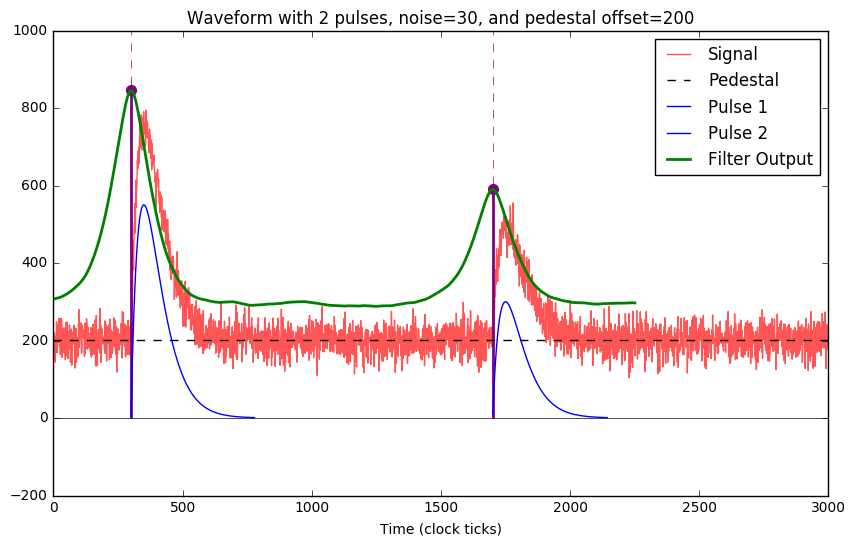

In [7]:
pulse_list=np.array([[300,550],[1700,300]])
demo_matched_filter(pulse_list,template,noise=30,pedestal=200,peak_threshold=500)

## A Pulse Filter that's Orthogonal to the Pedestal

In [8]:
def orthogonalise(original,remove,return_all=False):
    """ Orthogonalise and normalise a template ('original') against a second one ('remove')
    """
    correl=np.dot(remove,original)/np.dot(remove,remove)
    orthogonal=original - correl* remove
    #return orthogonal
    normalisation=np.dot(original,original)/np.dot(orthogonal,original)
    print("Orthogonalised normalisation:",normalisation)
    if return_all:
        return orthogonal, orthogonal*normalisation
    return orthogonal*normalisation

Orthogonalised normalisation: 1.36294


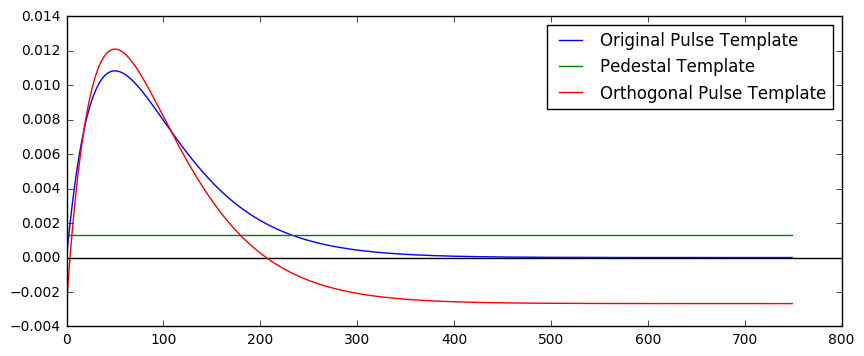

In [9]:
# Make the pedestal template and normalise it
pedestal_tpl=np.ones_like(template)
pedestal_tpl/=np.dot(pedestal_tpl,pedestal_tpl)

# Produce the orthogonalised pulse template
ortho_pulse_tpl=orthogonalise(template,pedestal_tpl,return_all=False)

plt.figure(figsize=(10,4))
plt.plot(template,label="Original Pulse Template")
plt.plot(pedestal_tpl,label="Pedestal Template")
plt.plot(ortho_pulse_tpl,label="Orthogonal Pulse Template")
plt.hlines(0,*plt.xlim())
plt.legend()

Low noise:
Found 2 pulses compared to 2 original pulses:
  Recovered:   time   amplitude
           0     300    752.233
           1    1699    501.234
  Original:    time   amplitude  pedestal
           0     300        750       300
           1    1700        500       300
High noise:
Found 6 pulses compared to 2 original pulses:
  Recovered:   time   amplitude
           0     298    732.743
           1     300    732.356
           2    1692    526.456
           3    1700    534.289
           4    1704    530.581
           5    1706     529.78
  Original:    time   amplitude  pedestal
           0     300        750       300
           1    1700        500       300


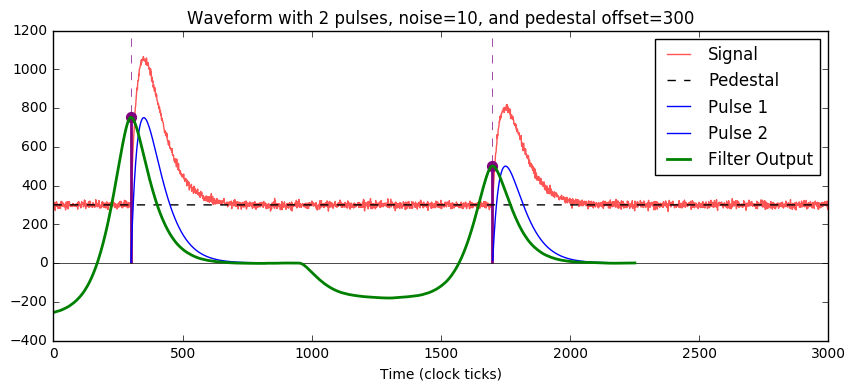

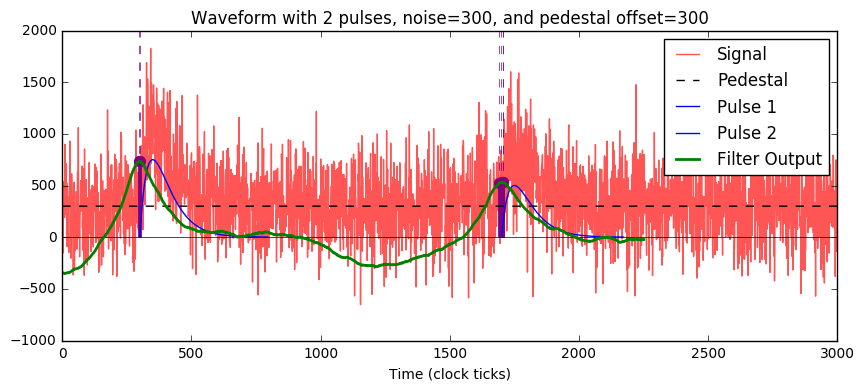

In [10]:
pulse_list=np.array([[300,750],[1700,500]])
plt.figure(figsize=(10,4))
print("Low noise:")
demo_matched_filter(pulse_list,ortho_pulse_tpl,noise=10,pedestal=300,peak_threshold=400)
plt.figure(figsize=(10,4))
print("High noise:")
demo_matched_filter(pulse_list,ortho_pulse_tpl,noise=300,pedestal=300,peak_threshold=460)

# 4. Pile-up Separation with Orthogonal Filters
Another common problem encountered in particle physics arises when two pulses overlap, caused by the detection of two different particles by the same detector channel within less that time than the response time of the channel. This issue is known as 'pile-up' since the responses pile up on top of one another.

In this case, the signal becomes:
$$
S_i=aT_{i-k} + b T_{i-m} + \epsilon_i
$$
where $k$ and $m$ give the offset of each pulses.

This is another example where the normal pulse filter would stop working, since it will receive a contribution from each of the pile-up pulses.  This will affect both the recovered pulse's amplitude and time and will cause fewer pulses to be identified.

## An Example of Pile-up on a Simple Matched Filter

Found 2 pulses compared to 4 original pulses:
  Recovered:   time   amplitude
           0     302    790.975
           1    1377    559.278
  Original:    time   amplitude  pedestal
           0     300        750         0
           1     450        200         0
           2    1300        350         0
           3    1400        400         0


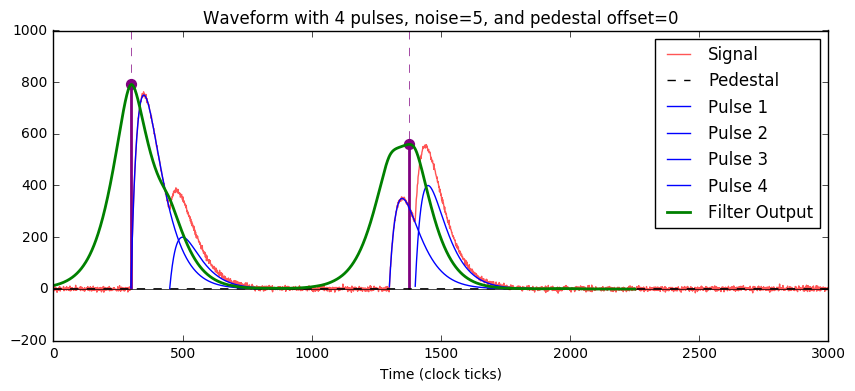

In [11]:
plt.figure(figsize=(10,4))
pulse_list=np.array([[300,750],[450,200],[1300,350],[1400,400]])
demo_matched_filter(pulse_list,template,noise=5,pedestal=0,peak_threshold=100)

## A Filter that is Orthogonal to Pile-up of a Given Offset

The time between the first and second pulses in a pile-up waveform can take any value.  
However, if we knew the time between pulses, we can orthogonalise the pulse template to ignore the contribution from the first pulse:

Orthogonalised normalisation: 2.18005
Orthogonalised normalisation: 4.84347


(-0.01, 0.025)

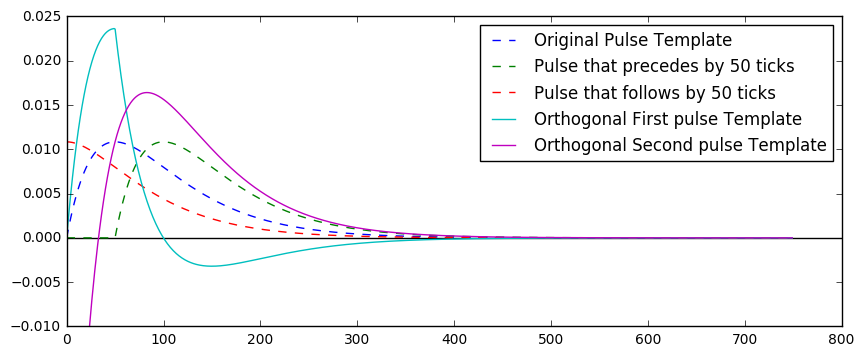

In [12]:
# Make the pedestal template and normalise it
pileup_offset=50
pileup_tpl_1=response(tpl_x,shape_time=shaping_time,offset=pileup_offset)
pileup_tpl_2=response(tpl_x,shape_time=shaping_time,offset=-pileup_offset)
norm=np.dot(pileup_tpl_1,pileup_tpl_1)
# Match the normalisation of the two offset pulses
pileup_tpl_1/=norm
pileup_tpl_2/=norm

# Produce the orthogonalised pulse template
ortho_pileup_tpl_1=orthogonalise(template,pileup_tpl_1)
ortho_pileup_tpl_2=orthogonalise(template,pileup_tpl_2)

plt.figure(figsize=(10,4))
plt.plot(template,label="Original Pulse Template",ls="--")
plt.plot(pileup_tpl_1,label="Pulse that precedes by "+str(pileup_offset)+" ticks",ls="--")
plt.plot(pileup_tpl_2,label="Pulse that follows by "+str(pileup_offset)+" ticks",ls="--")
plt.plot(ortho_pileup_tpl_1,label="Orthogonal First pulse Template")
plt.plot(ortho_pileup_tpl_2,label="Orthogonal Second pulse Template")
plt.hlines(0,*plt.xlim())
plt.legend(loc="upper right")
plt.ylim([-0.01,0.025])

Found 2 pulses compared to 2 original pulses:
  Recovered:   time   First Pulse Filter  Second Pulse Filter
           0     500             754.613             1394.983
           1     550            1161.263              444.789
Found 2 pulses compared to 2 original pulses:
  Recovered:   time   Peak Heights
           0     475      1661.687
           1     549      1161.386
  Original:    time   amplitude  pedestal
           0     500        750         0
           1     550        450         0


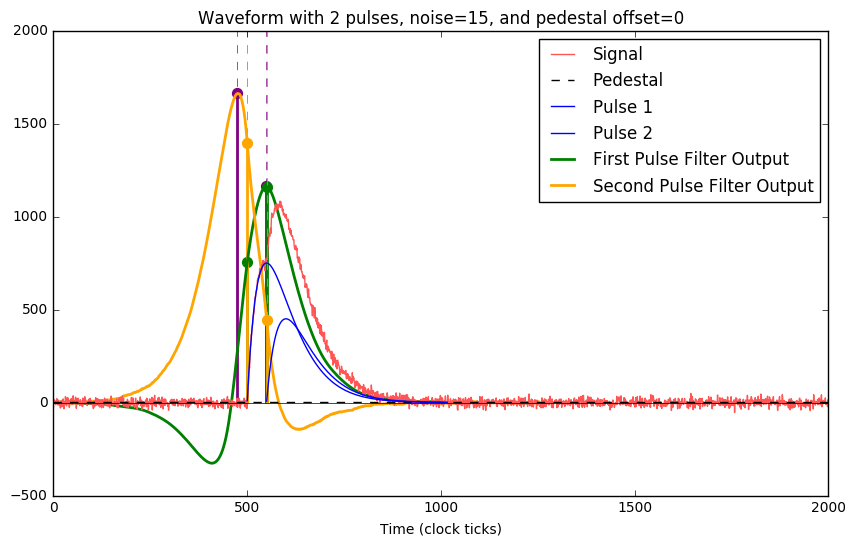

In [13]:
# Show the output of the filter at the true peaks
def demo_pileup_filter(pulse_list,pulse_1_tpl,pulse_2_tpl,noise,pedestal=0,peak_threshold=None):
    if not peak_threshold: peak_threshold=noise*1.5+pedestal*1.5
    wf=Waveform(pulse_list,noise=noise,shaping_time=shaping_time,length=2000,pedestal=pedestal)
    pulse_filters=[ matched_filter(wf,filt) for filt in [pulse_1_tpl,pulse_2_tpl] ]

    # Plot the waveform and the filter outputs
    # Need two loops to help the plot's y-axis look reasonable
    wf.plot_all()
    titles=["First","Second"]
    colours=["green","orange"]
    peaks=[]
    maximum=None
    for i,filtered in enumerate(pulse_filters):
        plt.plot(wf.x[:len(filtered)],filtered,label=titles[i]+" Pulse Filter Output",color=colours[i],lw=2,zorder=-1)
    for i,filtered in enumerate(pulse_filters):
        peaks.append(find_peaks(filtered,peak_threshold))
        plot_peaks(peaks[-1],filtered,zorder=-1)
        plot_peaks(pulse_list[:,0],filtered,colour=colours[i],zorder=-1)
    plt.legend()
    
    # Sort the peaks found directly on the filters into lists for the compare() function
    heights=np.array([ p for filtered,peak in zip(pulse_filters,peaks) for p in  filtered[peak] ])
    peaks=np.array([ peak for peak_list in peaks for peak in peak_list ])
    index=np.argsort(peaks)
    
    # Print the various amplitudes and times out
    wf.compare(pulse_list[:,0],pulse_filters,[tit+" Pulse Filter" for tit in titles],print_true=False)
    wf.compare(peaks[index],[heights[index]],"Peak Heights")

pulse_list=np.array([[500,750],[500+pileup_offset,450]])#,[1500,750]])#,[1000+pileup_offset,200]])
demo_pileup_filter(pulse_list,ortho_pileup_tpl_1,ortho_pileup_tpl_2,noise=15,peak_threshold=400)

That's a little bit awkward to interpret what's going on, so to explain:
1. The purple peak markers show the peaks that one recovers from the output of the two filters. This would be the naive values for the recovered amplitudes of the underlying pulse(s): clearly these are not useable directly like this since each filter only sees one peak and the amplitudes and times of these peaks do not agree well with the true values.
2. The green peak markers indicate the value of the "First Pulse" filter at the true times of the underlying pulses.  This filter is supposed to recover the amplitude of the first pulse in the pile-up event, and indeed the output of this filter at the true time of the first pulse agrees with the true amplitude of that pulse.
3. Similarly the orange peak markers indicate the value of the "Second Pulse" filter output. Again, at the true time of the second pulse, this filter gives the true amplitude.

So we have a few problems to tackle to pursue this approach.  Namely:
1. We only observe one pulse per filter, despite the fact that there are two underlying ones.
2. We need to know the 'true' time of the underlying pulse before we know where to read off on each filter.
3. We have assumed the pile-up separation time is known in advance.

# 5. Recovering the Time of Pile-up Pulses: a Pedestal-Orthogonal Rising-Edge Filter

The key challenge of the previous approch for pile-up recovery is that we could not tell accurately when a pulse began.
Each pulse contributed too much to the two filters, so no clear separation was visible.  

One potential solution is to use a much shorter template in the filter.  This would reduce the amount a pile-up pulse contributes to the response over a previous or subsequent.  In addition, if a pulse sits on the tail of a preceding pulse, it's amplitude will be skewed.  

Thus we make a new pulse finding filter which:
1. Only covers the rising edge of the pulse's shape
2. Is orthogonal to a shifting pedestal (which for now we consider as flat)

**Note** Until now we have been fairly agnostic to the shape of the pulse being used, providing it was finite in length.  At this point, we start to make use of specific features of the pulse shape, namely the steep rising edge, and gradually falling trailing edge.

Orthogonalised normalisation: 5.39946


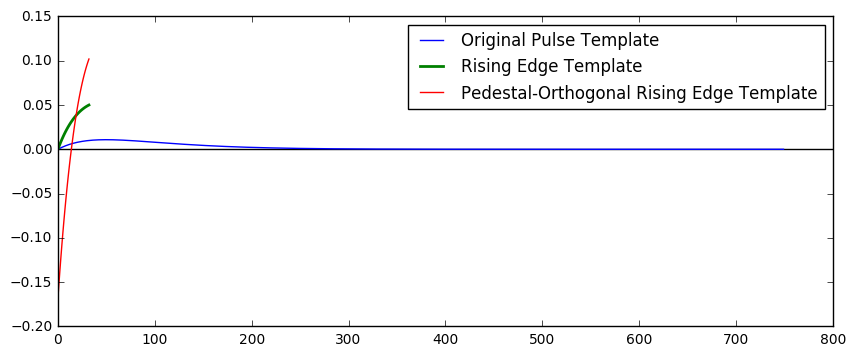

In [14]:
# Make a filter with just the rising edge of the pulse:
finder_len=int(shaping_time*2/3.)
finder_tpl=response(tpl_x[:finder_len],shape_time=shaping_time,offset=0)
# Since we don't intend to use the amplitude directly, the normalisation here is not particularly important
# So we set this so that the output of the filter appears on the plot well
finder_tpl*=0.05
#finder_tpl=finder_tpl[4:]

# Orthogonalise it w.r.t. a flat pedestal:
ortho_finder=orthogonalise(original=finder_tpl,remove=np.ones_like(finder_tpl))

plt.figure(figsize=(10,4))
plt.plot(template,label="Original Pulse Template")
plt.plot(finder_tpl,linewidth=2,label="Rising Edge Template")
plt.plot(ortho_finder,label="Pedestal-Orthogonal Rising Edge Template")
plt.hlines(0,*plt.xlim())
plt.legend()

Found 5 pulses compared to 4 original pulses:
  Recovered:   time   amplitude
           0     496    588.091
           1     544    301.447
           2    1493    168.107
           3    1496    170.929
           4    1621    391.826
  Original:    time   amplitude  pedestal
           0   500.0      750.0        50
           1   550.0      450.0        50
           2  1500.0      220.0        50
           3  1625.0      550.0        50


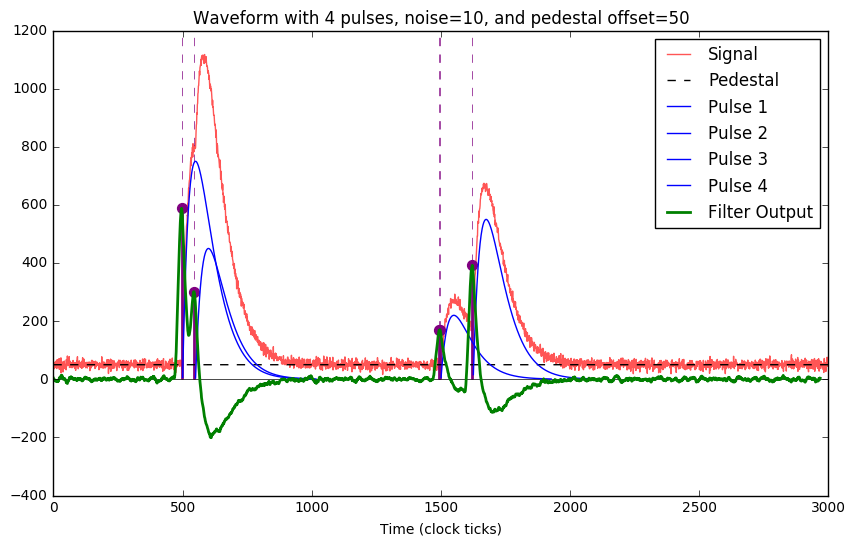

In [15]:
pulse_list=np.array([[500,750],[500+pileup_offset,450],[1500,220],[1500+pileup_offset*2.5,550]])
demo_matched_filter(pulse_list,ortho_finder,noise=10,pedestal=50,peak_threshold=160)

This demonstrates the feasability of such a filter, although by looking at the recovered times, it is likely to need a degree of calibration (a small offset being applied).  What's more it can be seen that this does not require any knowledge about the underlying pile-up offset, and as such can be run online without much concern.

On the other hand, the filter is clearly more sensitive to noise, primarily because it is summing over fewer samples.

## Combining with the pile-up orthogonalised filters
With a good estimate of the time of underlying pile-up events, information from the pile-up orthogonal filters shown in the previous section can now be recovered.  The following algorithm is one way this could work:
1. Scan the waveform with the pulse-finding filter (matched to the rising-edge and orthogonalised to the pedestal)
2. Group the identified pulses into collections of piled-up pulses (ie. collect those that occur within less time than the response time of the channel)
3. For each collection of piled-up pulses:
  1. Calculate the offsets between every pulse in the set
  2. Choose the relevant, pile-up orthogonalised filter (which could have been calculated in advance, for the range of possible pile-up offsets)
  3. Calculate the output of the selected filters at the identified times (so there is no need to look at the filter's output across the waveform).

Orthogonalised normalisation: 6.23149
Orthogonalised normalisation: 3.1583
Orthogonalised normalisation: 4.84347
Orthogonalised normalisation: 2.18005
Orthogonalised normalisation: 3.16185
Orthogonalised normalisation: 1.19736

Indentified pile-up separation: 36
Recovered amplitudes: 791.803925451 966.375707206
Compared to true amplitudes: 750.0 950.0
Recovered times: 301 337
Compared to true times: 300.0 337.5


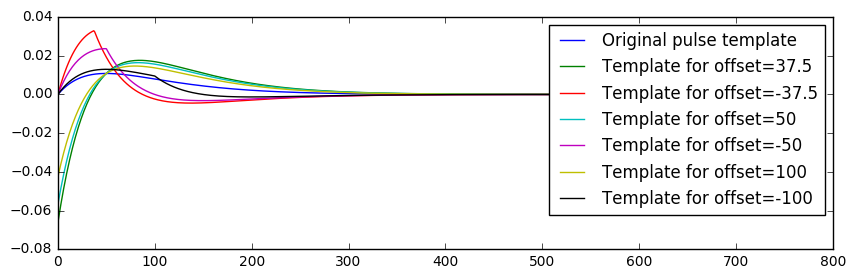

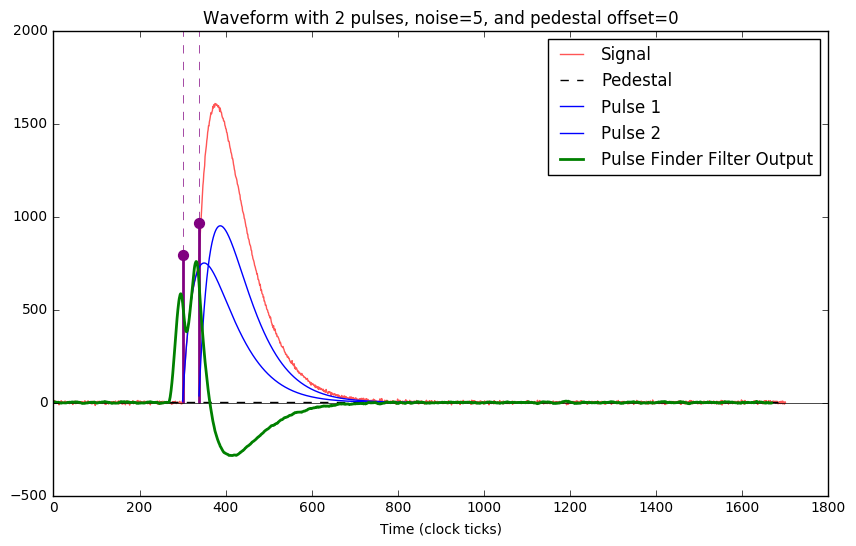

In [16]:
def demo_finder_and_pileup_filters(
            pulse_list,finder_tpl,
            possible_pu_offsets,noise,pedestal=0,peak_threshold=None,finder_offset=0):
    if len(pulse_list)!=2:
        print("This is only a demo, and only works with two true, for now")
        return
    
    # Make the pile-up orthogonalised filters:
    plt.figure(figsize=(10,3))
    pu_filters={}
    plt.plot(template,label="Original pulse template")
    for mag_offset in possible_pu_offsets:
        for offset in [mag_offset,-mag_offset]:
            tpl=response(tpl_x,shape_time=shaping_time,offset=-offset)
            tpl*=np.max(template)
            ortho_tpl=orthogonalise(original=template,remove=tpl)
            pu_filters[offset]=ortho_tpl
            plt.plot(ortho_tpl,label="Template for offset="+str(offset))
    plt.legend()
    
    # Make the waveform and apply the filter
    wf=Waveform(pulse_list,noise=noise,shaping_time=shaping_time,length=1700,pedestal=pedestal)
    finder_filter=matched_filter(wf,finder_tpl)
    
    # Plot the waveform and the filter outputs
    plt.figure()
    wf.plot_all()
    plt.plot(wf.x[:len(finder_filter)],finder_filter,label="Pulse Finder Filter Output",color="green",lw=2)
    
    # Find the contained pulses:
    if not peak_threshold: peak_threshold=noise*1.5+pedestal*1.5
    pulse_times=find_peaks(finder_filter,peak_threshold)+finder_offset
    if len(pulse_times)!=2:
        print("Didn't find two pulses, so have to fail, since this is only a demo... Sorry!")
        return
    
    # Calculate the offsets and identify the best filter to apply
    pulse_sep=pulse_times[1]-pulse_times[0]
    pulse_offsets=[-pulse_sep,pulse_sep]
    filters=[]
    for i,real_offset in enumerate(pulse_offsets):
        # Find the closest offset
        best_offset=None
        for quantised_offset in pu_filters:
            diff=abs(quantised_offset-real_offset)
            if best_offset is None or diff < best_offset[0]:
                best_offset=(diff,quantised_offset)
            #print(quantised_offset,real_offset,best_offset)
        filters.append(pu_filters[best_offset[1]])
    
    # Apply the filters to the points where they're requested:
    peak_heights=[]
    for i,(start_time, filt) in enumerate(zip(pulse_times,filters)):
        stop_time=start_time+len(filt)
        peak_heights.append(np.dot(filt,wf.waveform[start_time:stop_time]))
        """filtered=matched_filter(wf,filt)
        plt.plot(filtered,"#"+str(992200+i*5000),label=str(start_time))"""
    plot_peaks(pulse_times,peak_heights)
    plt.legend()
    
    # Print stuff out:
    print()
    print("Indentified pile-up separation:",pulse_sep)
    print("Recovered amplitudes:",*peak_heights)
    print("Compared to true amplitudes:",*pulse_list[:,1])
    print("Recovered times:",*pulse_times)
    print("Compared to true times:",*pulse_list[:,0])
    
pu_offsets=[shaping_time/4.*3,shaping_time,shaping_time*2]
pulse_list=np.array([[300,750],[300+pu_offsets[np.random.randint(0,len(pu_offsets))],950]])
demo_finder_and_pileup_filters(pulse_list,ortho_finder,pu_offsets,noise=5,peak_threshold=150,finder_offset=5)

## Pile-up recovery with the original matched filter, the pulse finder filter and a bit of matrix arithmetic
Since we've established a reasonable technique at pulse-identification, there is one other approach that allows us to return to the original matched filter to obtain the underlying amplitudes.  Whether this is more stable or offers better resolution would need to be studied.

Defining our pile-up signal as before, we had:
$$
S_i=aT_{i-k} + b T_{i-m} + \epsilon_i
$$

With our matched filter's output given by:
\begin{align}
F_i = &a\sum_jT_{j}T_{j-k+i} + b\sum_jT_{j}T_{j-m+i} + \sum_jT_{j}\epsilon_{j+i}\\
    = &aT^2_{k-i} + bT^2_{m-i} + E_i\\
\end{align}

Where, in order to simplify things, we have defined:
\begin{align}
E_i=&\sum_jT_{j}\epsilon_{j+i}\\
T^2_k=&\sum_iT_iT_{i-k}
\end{align}
where the latter is essentially the template pulse's auto-correlation function, which is symmetric, $T^2_k=T^2_{-k}$.

At the time of the first and second pulse ($k$ and $m$ respectively), the filter output will be:
\begin{align}
F_k = & a T^2_0 + b T^2_{k-m} + E_k\\
F_m = & a T^2_{k-m} + b T^2_0 + E_m\\
\end{align}
which we can rewrite as a matrix equation (and we drop the error terms,  which would average to 0):
\begin{align}\left(
 \begin{matrix}
  F_k\\
  F_m
 \end{matrix}
 \right) = \left(
 \begin{matrix}
  T^2_0 & T^2_{k-m}\\
  T^2_{k-m} & T^2_{0}\\
 \end{matrix} \right)
 \left(
 \begin{matrix}
  a\\
  b
 \end{matrix}
 \right)
\end{align}
Therefore, to extract the parameters $a$ and $b$ from the matched filter, given that we know the offset of the two pulses ($k-m$), we simply need to do the inverse:
\begin{align}\left(
 \begin{matrix}
  a\\
  b
 \end{matrix}
 \right) = 
 \left(
 \begin{matrix}
  T^2_0 & T^2_{k-m}\\
  T^2_{k-m} & T^2_{0}\\
 \end{matrix} \right)^{-1}
 \left(
 \begin{matrix}
  F_k\\
  F_m
 \end{matrix}
 \right)
\end{align}

Thus, one can calculate in advance the template's autocorrelation function, $T^2_i$, and the value of the matrix determinant for a given $(k-m)$, $\left(T^2_0\right)^2 - \left(T^2_{k-m}\right)^2$ and the underlying amplitudes can be directly recovered from the matched filter.

The additional advantage here is that this is easily extended to $>2$ pile-up: we just increase the rank of the matrix.


In [17]:
class Deconvolve():
    def __init__(self,shape):
        self.shape=shape
        self.autocorrelation=np.correlate(shape,shape,mode="full")
        self.autocorrelation=self.autocorrelation[int(len(self.autocorrelation)/2):]
        self.autocorrelation/=self.autocorrelation[0]
        self.determinant=1-self.autocorrelation**2
    
    def correlation(self,offset):
        offset=abs(offset)
        if offset>len(self.autocorrelation):
            return 0
        return self.autocorrelation[abs(offset)]
    
    def getTrueAmplitudes(self,times,filtered):
        if len(times)==1:
            return filtered
        if len(times)!=2:
            print("getTrueAmplitudes is not implemented for more than 2 peaks")
            return filtered
        
        offset=times[1]-times[0]
        pulse_1,pulse_2=filtered
        true_1=(filtered[0] - self.autocorrelation[offset]*filtered[1])/self.determinant[offset]
        true_2=(filtered[1] - self.autocorrelation[offset]*filtered[0])/self.determinant[offset]
        output=np.array([true_1,true_2])
        return output

def demo_finder_filter(pulse_list,pulse_tpl,finder_tpl,deconvolver,noise,pedestal=0,finder_offset=5,peak_threshold=None):
    if len(pulse_list)!=2:
        print("This is only a demo, and only works with two true, for now")
        return
    
    # Make the waveform and run the filters
    wf=Waveform(pulse_list,noise=noise,shaping_time=shaping_time,length=2000,pedestal=pedestal)
    pulse_filter=matched_filter(wf,pulse_tpl)
    finder_filter=matched_filter(wf,finder_tpl)[:len(pulse_filter)]
    wf.plot_all()
    plt.plot(wf.x[:len(pulse_filter)],pulse_filter,label="Pulse filter",color="green",linewidth=2)
    plt.plot(finder_filter,label="Pulse Finder",color="orange",linewidth=2)
    
    # Find the peaks
    if not peak_threshold: peak_threshold=noise*1.5+pedestal*1.5
    peaks=find_peaks(finder_filter,peak_threshold)+finder_offset
    if len(peaks)!=2:
        print("Found "+str(len(peaks))+" pulses, so have to fail, since this is only a demo... Sorry!")
        plot_peaks(peaks,pulse_filter,"orange")
        plt.legend(loc="best",ncol=2)
        return
    
    # Deconvolve the amplitudes
    amplitudes=deconvolver.getTrueAmplitudes(peaks,pulse_filter[peaks])
    plot_peaks(peaks,amplitudes,"purple")
    plt.legend(loc="best",ncol=2)
    wf.compare(peaks,[pulse_filter,amplitudes],["Filtered","Recovered"],precision=2)

deconvolver=Deconvolve(template)

Found 2 pulses compared to 2 original pulses:
  Recovered:   time   Filtered  Recovered
           0     500     531.5     451.47
           1     601    380.67     200.14
  Original:    time   amplitude  pedestal
           0     500        450         0
           1     600        200         0


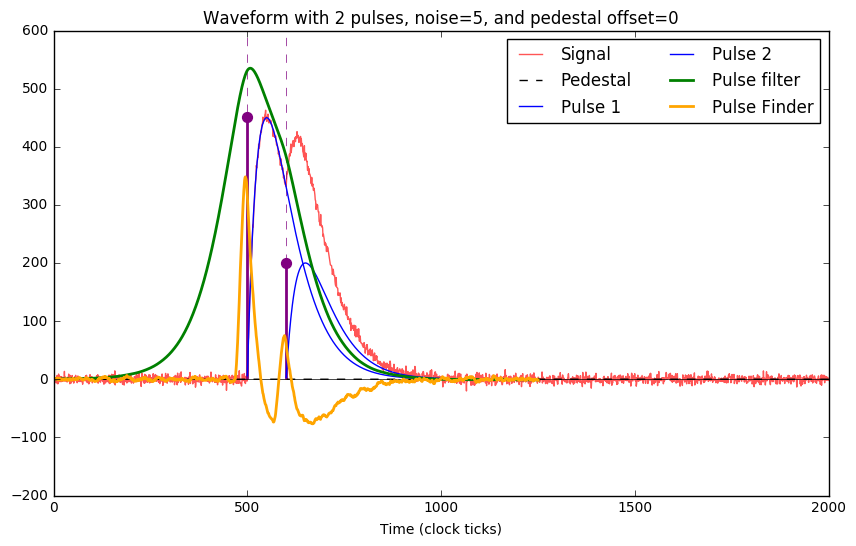

In [18]:
peak_time=300
pulse_list=np.array([[500,450],[600,200]])#,[1500,500]])
demo_finder_filter(pulse_list,template,ortho_finder,deconvolver,noise=5,pedestal=0,peak_threshold=40)

# 6. Future Areas for Development
There are many aspects of this that can be developed further:
 * **Peak Identification** The approach used here to identify a peak (search for maxima that are above a given threshold) might not be suitable for online routines, and may not be the most performant method.  For example, a high-low double threshold technique might be easier, or more traditional online routines such as constant fraction above a threshold should be investigated.
 * **Performance evaulation:** What values of pile-up separation and relative amplitudes can be resolved. What is the resolution of the various methods proposed here?
 * **Understanding noise after orthogonalisation:** How does the orthogonalisation procedure affect the signal to noise ratio?
 * **Template formation:**  Throughout this discussion we have assumed the exact form of each component in the signal is known in advance. In real-world situations this is often not the case. An empirically deduced template must be formed using pulse averaging. Similar techniques such as shown here might be helpful at that stage.
 * **Real-world noise:** We have demonstrated the various filters using pure white-noise, but real noise will not be truly Gaussian, and will have some Fourier components stronger than others.  It's important to test the robustness of these filters using more realistic noise then.
 * **Suitability for online running:** We have assumed that up to about 600 or so weights can be stored to describe a single filter. In addition, we have suggested that many different filters be run in parallel.  Whilst these approaches are not likely to cause an issue in an offline situation, they might be prohibitive in running the filters online, such as in an FPGA, for example.  Testing this approach using fewer filter weights (<10) and fewer filters is important

# And One Last Bonus: How about a Chi-2 filter?
The $\chi^2$ of the a given template is defined as:
\begin{align}
\chi^2 =& \sum_i \left(y_i - aT_i\right)^2\\
 = & \sum_i \left(y_i^2 - 2aT_iy_i + a^2T_i^2\right)\\
 = & \sum_iy_i^2 - 2a\sum_iT_iy_i + a^2\sum_iT_i^2
\end{align}

but the minimum value of $\chi^2$ was shown to occur when:
$$
a = \frac{\sum_i T_iy_i}{\sum_j T_j^2}
$$
so that the minimum $\chi^2$ is given by:

\begin{align}
\chi^2_\textrm{min}  = &  \sum_iy_i^2 
                         - 2 \left(\frac{\sum_i T_iy_i}{\sum_j T_j^2}\right) \sum_iT_iy_i
                         + \left(\frac{\sum_i T_iy_i}{\sum_j T_j^2}\right)^2\sum_iT_i^2 \\
                     = &  \sum_iy_i^2 
                         - 2\frac{\left(\sum_iT_iy_i\right)^2}{\sum_j T_j^2} 
                         + \frac{\left(\sum_i T_iy_i\right)^2}{\sum_j T_j^2} \\
                     = &  \sum_iy_i^2 
                         - \frac{\left(\sum_iT_iy_i\right)^2}{\sum_j T_j^2} \\
                         = &  \sum_iy_i^2 - a^2\sum_j T_j^2
\end{align}